In [50]:
import requests
import json
import numpy as np
import datetime
import string
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import itertools

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [51]:
energy_demand_daily = pd.read_csv('demanda_electrica_diaria.csv')
energy_demand_daily.set_index("date", inplace=True)

energy_demand_daily.index.freq = 'D'

In [52]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
def optimize_SARIMAX(endog , exog, order_list: list, d: int, D: int,  s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [53]:
train_sarimax = energy_demand_daily.loc['2014':'2021']
train_sarimax

,value,weekday,working_day
date,,,
2014-01-01,3315035.0,2,0
2014-01-02,4059590.0,3,1
2014-01-03,4098986.0,4,1
2014-01-04,3867911.0,5,1
2014-01-05,3648038.0,6,1
...,...,...,...
2020-12-27,3687140.0,6,1
2020-12-28,4149036.0,0,1
2020-12-29,4185143.0,1,1


In [54]:
test_sarimax = energy_demand_daily.loc['2021':'2022']
test_sarimax

,value,weekday,working_day
date,,,
2021-01-01,3447073.0,4,0
2021-01-02,3867892.0,5,1
2021-01-03,3899502.0,6,1
2021-01-04,4563905.0,0,1
2021-01-05,4647728.0,1,1
...,...,...,...
2021-12-27,3686647.0,0,1
2021-12-28,3729169.0,1,1
2021-12-29,3692921.0,2,1


In [55]:
exo_train = train_sarimax

del exo_train['value']
del exo_train['weekday']

exo_train

,working_day
date,
2014-01-01,0
2014-01-02,1
2014-01-03,1
2014-01-04,1
2014-01-05,1
...,...
2020-12-27,1
2020-12-28,1
2020-12-29,1


In [56]:
exo_test = test_sarimax

del exo_test['value']
del exo_test['weekday']

exo_test

,working_day
date,
2021-01-01,0
2021-01-02,1
2021-01-03,1
2021-01-04,1
2021-01-05,1
...,...
2021-12-27,1
2021-12-28,1
2021-12-29,1


In [57]:
train_sarimax = energy_demand_daily.loc['2014':'2021']

del train_sarimax['working_day']
del train_sarimax['weekday']

train_sarimax

,value
date,
2014-01-01,3315035.0
2014-01-02,4059590.0
2014-01-03,4098986.0
2014-01-04,3867911.0
2014-01-05,3648038.0
...,...
2020-12-27,3687140.0
2020-12-28,4149036.0
2020-12-29,4185143.0


In [58]:
test_sarimax = energy_demand_daily.loc['2021':'2022']

del test_sarimax['working_day']
del test_sarimax['weekday']

test_sarimax

,value
date,
2021-01-01,3447073.0
2021-01-02,3867892.0
2021-01-03,3899502.0
2021-01-04,4563905.0
2021-01-05,4647728.0
...,...
2021-12-27,3686647.0
2021-12-28,3729169.0
2021-12-29,3692921.0


In [59]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

from itertools import product

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [60]:
result_df = optimize_SARIMAX(train_sarimax, exo_train, parameters_list, d, D, s)
# result_df

/tmp/ipykernel_22033/2332496891.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/berni/anaconda3/lib/python3.8/site-packages/statsm

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

In [61]:
result_df

,"(p,q,P,Q)",AIC
0,"(3, 2, 3, 3)",68582.465219
1,"(3, 2, 3, 2)",68725.223056
2,"(2, 2, 3, 3)",68951.372986
3,"(3, 2, 3, 1)",69160.244902
4,"(3, 2, 2, 1)",69187.676405
...,...,...
250,"(1, 0, 2, 0)",72043.030974
251,"(1, 0, 1, 0)",72044.647335
252,"(0, 1, 0, 0)",72064.722208
253,"(1, 0, 0, 0)",72080.398958


In [62]:
# p, d, q
# P, D, Q, s

# (p,q,P,Q) = (3, 2, 3, 3)

# order = (p,d,q) = (3, 2, 1)
# seasonal_order = (P,D,Q,s) = (3, 0, 3, 4)

model_sarimax = SARIMAX(
    train_sarimax,
    exo_train,
    order=(3, 2, 1),
    seasonal_order=(3, 0, 3, 4)
).fit()

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42397D+01    |proj g|=  2.19122D-01

At iterate    5    f=  1.40020D+01    |proj g|=  1.13259D-01

At iterate   10    f=  1.39186D+01    |proj g|=  8.89187D-02

At iterate   15    f=  1.39020D+01    |proj g|=  3.82218D-01

At iterate   20    f=  1.38937D+01    |proj g|=  8.37449D-02

At iterate   25    f=  1.38902D+01    |proj g|=  2.47523D-02

At iterate   30    f=  1.38879D+01    |proj g|=  1.00708D-01

At iterate   35    f=  1.38875D+01    |proj g|=  3.81217D-02

At iterate   40    f=  1.38873D+01    |proj g|=  1.38669D-01

At iterate   45    f=  1.38864D+01    |proj g|=  1.96252D-02


/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.38855D+01    |proj g|=  4.32537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   4.325D-02   1.389D+01
  F =   13.885477822791181     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [63]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     value   No. Observations:                 2557
Model:             SARIMAX(3, 2, 1)x(3, 0, [1, 2, 3], 4)   Log Likelihood              -35505.167
Date:                                   Sat, 02 Jul 2022   AIC                          71034.334
Time:                                           21:31:24   BIC                          71104.483
Sample:                                       01-01-2014   HQIC                         71059.773
                                            - 12-31-2020                                         
Covariance Type:                                     opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
working_day  3.378e+05   1.43e-08   2.36e+13      0.000    3.38e+05    3.38e+05
ar.L1           0.1921      0.045      4.270      0.000       0.104       0.280
ar.L2           0.0072      0.037      0.193      0.847      -0.066       0.080
ar.L3          -0.5916      0.043    -13.636      0.000      -0.677      -0.507
ma.L1          -0.9975      0.022    -45.724      0.000      -1.040      -0.955
ar.S.L4         0.2549      0.016     15.893      0.000       0.223       0.286
ar.S.L8         0.2370      0.020     11.916      0.000       0.198       0.276
ar.S.L12       -0.9914      0.016    -62.011      0.000      -1.023      -0.960
ma.S.L4        -0.2465      0.054     -4.571      0.000      -0.352      -0.141
ma.S.L8        -0.2629      0.065     -4.037      0.000      -0.391      -0.135
ma.S.L12        0.9834      0.053     18.717      0.000       0.880       1.086
sigma2        1.37e+11    1.3e-12   1.06e+23      0.000    1.37e+11    1.37e+11
===================================================================================
Ljung-Box (L1) (Q):                 338.13   Jarque-Bera (JB):                50.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+36. Standard errors may be unstable.
"""

In [64]:
y_pred_sarimax = model_sarimax.predict(start='2021-01-01', end='2021-12-31', exog = exo_test, dynamic=True)
y_pred_sarimax

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-01-01    3.666450e+06
2021-01-02    3.634319e+06
2021-01-03    3.769622e+06
2021-01-04    4.120638e+06
2021-01-05    4.254867e+06
                  ...     
2021-12-27    4.009647e+06
2021-12-28    3.997770e+06
2021-12-29    3.761978e+06
2021-12-30    3.879332e+06
2021-12-31    4.084630e+06
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [65]:
test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)

/tmp/ipykernel_22033/2905224860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)


In [66]:
test_sarimax

,value,value_sarimax
date,,
2021-01-01,3447073.0,3.666450e+06
2021-01-02,3867892.0,3.634319e+06
2021-01-03,3899502.0,3.769622e+06
2021-01-04,4563905.0,4.120638e+06
2021-01-05,4647728.0,4.254867e+06
...,...,...
2021-12-27,3686647.0,4.009647e+06
2021-12-28,3729169.0,3.997770e+06
2021-12-29,3692921.0,3.761978e+06


<AxesSubplot:xlabel='date'>

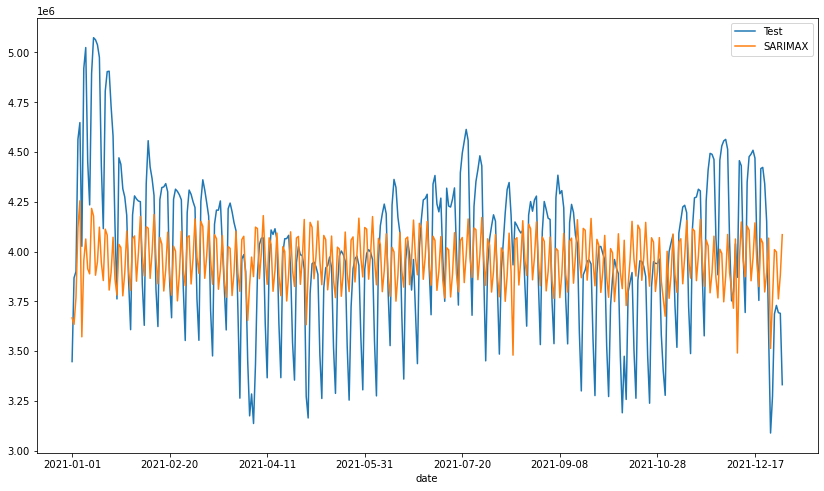

In [67]:
test_sarimax['value'].plot(legend=True, label='Test', figsize=(14,8))
test_sarimax['value_sarimax'].plot(legend=True, label='SARIMAX', figsize=(14,8))

In [68]:
rmse_sarimax = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mape_sarimax = mean_absolute_percentage_error(test_sarimax['value'],test_sarimax['value_sarimax'])

print(f'RMSE: {rmse_sarimax:11.10}')
print(f'MAPE: {mape_sarimax:11.10}')

RMSE: 1.212654134e+11
MAPE: 0.07004791899
